In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 10.1 MB/s 
     |████████████████████████████████| 588.3 MB 19 kB/s 
     |████████████████████████████████| 6.0 MB 56.7 MB/s 
     |████████████████████████████████| 1.7 MB 55.0 MB/s 
     |████████████████████████████████| 439 kB 74.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [3]:
import pandas as pd               #importing neccessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud

## Ignoring Warning during trainings 
import warnings
warnings.filterwarnings('ignore')
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
file_path = "/content/drive/MyDrive/train.csv"
raw_data = pd.read_csv(file_path)
print("Data points count: ", raw_data['id'].count())
raw_data.head()


Data points count:  7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

***Preprocessing Our raw Data***

In [6]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')


def clean_text(each_text):                                       #www.github.com

    # removing URL from text
    text_no_url = re.sub(r"http\S+", "", each_text)
    
    # removing numbers from text
    text_no_num = re.sub(r'\d+', '',text_no_url)

    # tokenize each text
    word_tokens = word_tokenize(text_no_num)
    
    # remove special character
    clean_text = []
    for word in word_tokens:
        clean_text.append("".join([e for e in word if e.isalnum()]))

    # remove stop words and lower
    text_with_no_stop_word = [w.lower() for w in clean_text if not w in stop_words]  

    # do stemming
    stemmed_text = [stemmer.stem(w) for w in text_with_no_stop_word]
    
    return " ".join(" ".join(stemmed_text).split())

raw_data['text'] = raw_data['text'].str.lower()
raw_data['clean_text'] = raw_data['text'].apply(lambda x: clean_text(x) )    # claeaning our text data

In [7]:
raw_data.drop(['text','id','location','keyword'],axis=1)      # removing useless features

,target,clean_text
0,1,deed reason earthquak may allah forgiv us
1,1,forest fire near la rong sask canada
2,1,resid ask shelter place notifi offic evacu she...
3,1,peopl receiv wildfir evacu order california
4,1,got sent photo rubi alaska smoke wildfir pour ...
...,...,...
7608,1,two giant crane hold bridg collaps nearbi home
7609,1,ariaahrari thetawniest control wild fire calif...
7610,1,utc km volcano hawaii
7611,1,polic investig ebik collid car littl portug eb...


In [8]:
X_train, X_test,y_train, y_test = model_selection.train_test_split(raw_data['clean_text'],
                                                                   raw_data['target'],
                                                                   test_size=0.3,
                                                                   random_state=21, 
                                                                   shuffle=True)


***Since keyword feature mostly has nan value and is of not much use for our problem, we will drop it.***

In [ ]:
# Vectorize text
vectorizer = CountVectorizer()
X_train1 = vectorizer.fit_transform(X_train)
X_test1 = vectorizer.transform(X_test)
print("Final Data matrix")
print(X_train1.shape, y_train.shape)


Final Data matrix
(5329, 11115) (5329,)


**Applying Random Forest**

In [ ]:
# Train another model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
params = {
'n_estimators' : [200, 700, 1000,1500, 2000],
'max_depth' : [15, 20, 25, 30, 35, 50] }
rf = RandomForestClassifier()
clf = RandomizedSearchCV(rf, params, verbose=10,n_jobs=-1)
clf.fit(X_train1,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [15, 20, 25, 30, 35, 50],
                                        'n_estimators': [200, 700, 1000, 1500,
                                                         2000]},
                   verbose=10)

In [ ]:
predicted_prob = clf.predict_proba(X_test1)
predicted = clf.predict(X_test1)

accuracy = metrics.accuracy_score(predicted, y_test)
print("Test accuracy: ", accuracy)
print(metrics.classification_report(y_test, predicted, target_names=["0", "1"]))
print("Test F-scoare: ", metrics.f1_score(y_test, predicted))

Test accuracy:  0.7745183887915937
              precision    recall  f1-score   support

           0       0.74      0.95      0.83      1322
           1       0.88      0.54      0.67       962

    accuracy                           0.77      2284
   macro avg       0.81      0.74      0.75      2284
weighted avg       0.80      0.77      0.76      2284

Test F-scoare:  0.6683837733419188


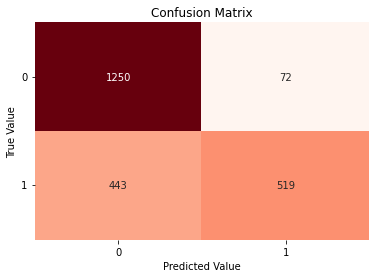

In [ ]:
conf_matrix = metrics.confusion_matrix(y_test, predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)

plt.show()

**Using our Deep Learning model** 

In [ ]:
path_to_glove_file = '/content/drive/MyDrive/glove.6B.300d.txt' # download link: http://nlp.stanford.edu/data/glove.6B.zip
embedding_dim = 300
learning_rate = 1e-3
batch_size = 1024
epochs = 20
sequence_len = 100

# Define train and test labels
y_train_LSTM = y_train.values.reshape(-1,1)
y_test_LSTM = y_test.values.reshape(-1,1)

print("Training Y shape:", y_train_LSTM.shape)
print("Testing Y shape:", y_test_LSTM.shape)

Training Y shape: (5329, 1)
Testing Y shape: (2284, 1)


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  11136


In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=sequence_len)  # padding
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=sequence_len)

print("Training X shape: ", X_train.shape)
print("Testing X shape: ", X_test.shape)


Training X shape:  (5329, 100)
Testing X shape:  (2284, 100)


In [ ]:
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=sequence_len,
                                            trainable=False)


In [ ]:
sequence_input = Input(shape=(sequence_len, ), dtype='int32')  #Model Architecture
embedding_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedding_sequences)
x = Bidirectional(LSTM(256, dropout=0.5, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          3340800   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           192128    
                                                                 
 bidirectional (Bidirectiona  (None, 512)              788480    
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [ ]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
6/6 [==============================] - 106s 16s/step - loss: 0.6842 - accuracy: 0.5607 - val_loss: 0.6508 - val_accuracy: 0.5788
Epoch 2/10
6/6 [==============================] - 94s 15s/step - loss: 0.6278 - accuracy: 0.6378 - val_loss: 0.5451 - val_accuracy: 0.7399
Epoch 3/10
6/6 [==============================] - 98s 16s/step - loss: 0.5582 - accuracy: 0.7547 - val_loss: 0.5018 - val_accuracy: 0.7706
Epoch 4/10
6/6 [==============================] - 94s 16s/step - loss: 0.5030 - accuracy: 0.7853 - val_loss: 0.4897 - val_accuracy: 0.7771
Epoch 5/10
6/6 [==============================] - 94s 16s/step - loss: 0.4724 - accuracy: 0.7985 - val_loss: 0.4967 - val_accuracy: 0.7750
Epoch 6/10
6/6 [==============================] - 102s 16s/step - loss: 0.4410 - accuracy: 0.8150 - val_loss: 0.4888 - val_accuracy: 0.7793
Epoch 7/10
6/6 [==============================] - 94s 15s/step - loss: 0.4181 - accuracy: 0.8268 - val_loss: 0.4952 - val_accuracy: 0.7824
Epoch 8/10
6/6 [=========

In [ ]:
predicted = model.predict(X_test, verbose=1, batch_size=10000)

y_predicted = [1 if each > 0.5 else 0 for each in predicted]

score, test_accuracy = model.evaluate(X_test, y_test, batch_size=10000)

print("Test Accuracy: ", test_accuracy)
print(metrics.classification_report(list(y_test), y_predicted))

1/1 [==============================] - 8s 8s/step - loss: 0.5069 - accuracy: 0.7820
Test Accuracy:  0.7819615006446838
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1322
           1       0.81      0.63      0.71       962

    accuracy                           0.78      2284
   macro avg       0.79      0.76      0.77      2284
weighted avg       0.79      0.78      0.78      2284



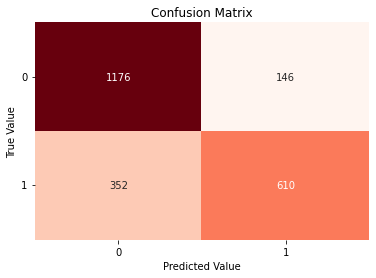

In [ ]:
conf_matrix = metrics.confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)
plt.show()

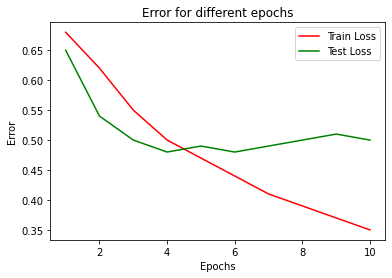

In [4]:
import matplotlib.pyplot as plt

epochs =[1,2,3,4,5,6,7,8,9,10] 
 

train_loss=[0.68,0.62,0.55,0.50,0.47,0.44,0.41,0.39,0.37,0.35]
test_loss=[0.65,.54,.50,.48,.49,.48,.49,.50,.51,.50] 
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.plot(epochs, test_loss, 'g', label='Test Loss')
plt.title('Error for different epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

***After 5th epoch our test error becomes almost constant while train error continue to reduce implying, with more epochs we will be overfitting.***

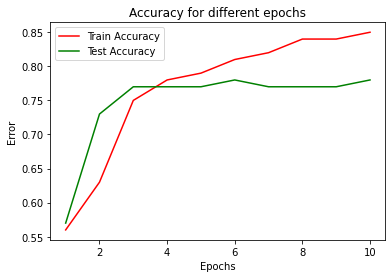

In [5]:
import matplotlib.pyplot as plt

epochs =[1,2,3,4,5,6,7,8,9,10] 
train_acc=[0.56,0.63,0.75,0.78,0.79,0.81,0.82,0.84,0.84,0.85]
test_acc=[0.57,.73,.77,.77,.77,.78,.77,.77,.77,.78] 
plt.plot(epochs, train_acc, 'r', label='Train Accuracy')
plt.plot(epochs, test_acc, 'g', label='Test Accuracy')
plt.title('Accuracy for different epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

***Our accuracy too becomes constant for test data after 5th epoch.***

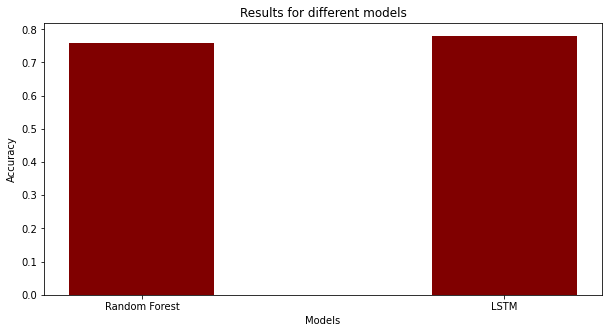

+---------------+----------+
|     Model     | Accuracy |
+---------------+----------+
| Random Forest |   0.76   |
|      LSTM     |   0.79   |
+---------------+----------+


***Using pretrained BERT model***

In [9]:
import tensorflow as tf                                 #https://www.analyticsvidhya.com/blog/2021/12/disaster-tweet-classification-using-bert-neural-network/
import tensorflow_hub as hub
import tensorflow_text as text

In [10]:
preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")  #downloading the encoder 
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [11]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text-layer')
preprocessed_text = preprocess(text_input)
outputs = encoder(preprocessed_text)
d_layer = tf.keras.layers.Dropout(0.1, name="dropout-layer")(outputs['pooled_output']) # Adding an additional Dense layer
d_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(d_layer)
model = tf.keras.Model(inputs=[text_input], outputs = [d_layer])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text-layer (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text-layer[0][0]']             
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [12]:
m= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=m)

In [15]:
model.fit(X_train, y_train, epochs=20)


Epoch 1/20
167/167 [==============================] - 58s 347ms/step - loss: 0.5600 - accuracy: 0.7288 - precision: 0.7222 - recall: 0.6081
Epoch 2/20
167/167 [==============================] - 56s 336ms/step - loss: 0.5579 - accuracy: 0.7238 - precision: 0.7154 - recall: 0.6020
Epoch 3/20
167/167 [==============================] - 57s 344ms/step - loss: 0.5542 - accuracy: 0.7341 - precision: 0.7282 - recall: 0.6163
Epoch 4/20
167/167 [==============================] - 57s 342ms/step - loss: 0.5508 - accuracy: 0.7330 - precision: 0.7281 - recall: 0.6124
Epoch 5/20
167/167 [==============================] - 57s 340ms/step - loss: 0.5525 - accuracy: 0.7258 - precision: 0.7137 - recall: 0.6133
Epoch 6/20
167/167 [==============================] - 57s 340ms/step - loss: 0.5558 - accuracy: 0.7285 - precision: 0.7168 - recall: 0.6172
Epoch 7/20
167/167 [==============================] - 57s 340ms/step - loss: 0.5488 - accuracy: 0.7328 - precision: 0.7282 - recall: 0.6115
Epoch 8/20
167/167 [

In [16]:
model.evaluate(X_test, y_test)

72/72 [==============================] - 25s 341ms/step - loss: 0.5215 - accuracy: 0.7574 - precision: 0.7772 - recall: 0.5946


[0.5215066075325012,
 0.7574430704116821,
 0.7771739363670349,
 0.5945945978164673]

***After running 30 epochs, we got an accuracy of 0.75. It is also not improving much.***

***Comparing our Models***

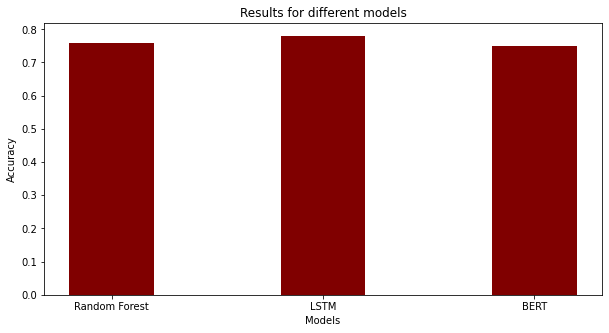

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10, 5))
model=['Random Forest','LSTM','BERT']
acc=[0.76,0.78,0.75]
# creating the bar plot
plt.bar(model[0:3], acc, color ='maroon',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Results for different models")
plt.show()


     

In [7]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Accuracy"]
x.add_row([ 'Random Forest',0.76])
x.add_row([ 'LSTM',0.79])
x.add_row([ 'BERT',0.75])
print(x)

+---------------+----------+
|     Model     | Accuracy |
+---------------+----------+
| Random Forest |   0.76   |
|      LSTM     |   0.79   |
|      BERT     |   0.75   |
+---------------+----------+


***Our LSTM performed the best followed by Random Forest and BERT.***